In [1]:
import os
import shutil
import glob
from tqdm import tqdm


#  RAW DATA
subject ID:
xxx

image number:
xxx

gender:
0 - male
1 - famale

glasses:
0 - no
1 - yes

eye state:
0 - close
1 - open

reflections:
0 - none
1 - low
2 - high

lighting conditions/image quality:
0 - bad
1 - good

sensor type:
01 - RealSense SR300 640x480
02 - IDS Imaging, 1280x1024
03 - Aptina Imagin 752x480

example:
s001_00123_0_0_0_0_0_01.png



In [2]:
RAW_DIR= r'/Users/ashish/Downloads/mrlEyes_2018_01'

In [3]:
for dirpath,dirname, filenames in os.walk(RAW_DIR):
    for i in tqdm([f for f in filenames if f.endswith('.png')]):
        if i.split('_')[4]=='0':
            shutil.copy(src=dirpath+'/'+i,dst=r'/Users/ashish/Downloads/EYE_DATA/CLOSED EYES')
        elif i.split('_')[4]=='1':
            shutil.copy(src=dirpath+'/'+i,dst=r'/Users/ashish/Downloads/EYE_DATA/OPEN EYES')


0it [00:00, ?it/s]
  0%|          | 0/1384 [00:00<?, ?it/s]

  0%|          | 0/1384 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ashish/Downloads/EYE_DATA/OPEN EYES'

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=0.2,shear_range=0.2,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,validation_split=0.2)

In [21]:
train_data=train_datagen.flow_from_directory(r"/Users/ashish/PycharmProjects/NULLCLASS/EYE_DATA/train",target_size=(80,80),batch_size=8,class_mode='categorical',subset='training')

Found 65365 images belonging to 2 classes.


In [22]:
validation_data=train_datagen.flow_from_directory(r"/Users/ashish/PycharmProjects/NULLCLASS/EYE_DATA/train",target_size=(80,80),batch_size=8,class_mode='categorical',subset='validation')

Found 16341 images belonging to 2 classes.


In [23]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_data=test_datagen.flow_from_directory(r"/Users/ashish/PycharmProjects/NULLCLASS/EYE_DATA/test",target_size=(80,80),batch_size=8,class_mode='categorical')

Found 3480 images belonging to 2 classes.


In [43]:
bmodel=InceptionV3(include_top=False,weights='imagenet',input_tensor=Input(shape=(80,80,3)))

In [44]:
hmodel=bmodel.output

In [45]:
bmodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 39, 39, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 39, 39, 32)           96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 39, 39, 32)           0         ['batch_normalizati

In [48]:
hmodel =Flatten()(hmodel)
hmodel =Dense(64,activation='relu')(hmodel)
hmodel=Dropout(0.5)(hmodel)
hmodel=Dense(2,activation='softmax')(hmodel)
model=Model(inputs=bmodel.input,outputs=hmodel)

In [49]:
for layer in bmodel.layers:
    layer.trainable=False

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 39, 39, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 39, 39, 32)           96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 39, 39, 32)           0         ['batch_normalization_37

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [56]:
checkpoint=ModelCheckpoint(r"/Users/ashish/PycharmProjects/NULLCLASS/EYE_MODEL",monitor='val_loss',save_best_only=True,verbose=3)
earlystop=EarlyStopping(monitor='val_loss',patience=7,verbose=3,restore_best_weights=True)
learning_rate=ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=3)
callbacks=[checkpoint,earlystop,learning_rate]

In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 8
history=model.fit_generator(train_data, steps_per_epoch=train_data.samples // batch_size,
                    validation_data=validation_data, validation_steps=validation_data.samples // batch_size,
                    epochs=1)

/var/folders/j1/2rcny1_96ss2fgzfgdq7z6qw0000gn/T/ipykernel_42744/2313648368.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_data, steps_per_epoch=train_data.samples // batch_size,


8170/8170 [==============================] - 379s 46ms/step - loss: 0.1791 - accuracy: 0.9362 - val_loss: 0.2349 - val_accuracy: 0.9166


In [76]:
acc_tr,loss_tr=model.evaluate_generator(train_data)
print(acc_tr)
print(loss_tr)


/var/folders/j1/2rcny1_96ss2fgzfgdq7z6qw0000gn/T/ipykernel_42744/3592745025.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc_tr,loss_tr=model.evaluate_generator(train_data)


KeyboardInterrupt: 

In [67]:
acc_vr,loss_vr=model.evaluate(validation_data)
print(acc_vr)
print(loss_vr)

2043/2043 [==============================] - 91s 45ms/step - loss: 0.2369 - accuracy: 0.9141
0.23689956963062286
0.914142370223999


In [69]:
acc_test,loss_test=model.evaluate(test_data)
print(acc_test)
print(loss_test)

435/435 [==============================] - 16s 37ms/step - loss: 0.2351 - accuracy: 0.9126
0.23512178659439087
0.9126436710357666


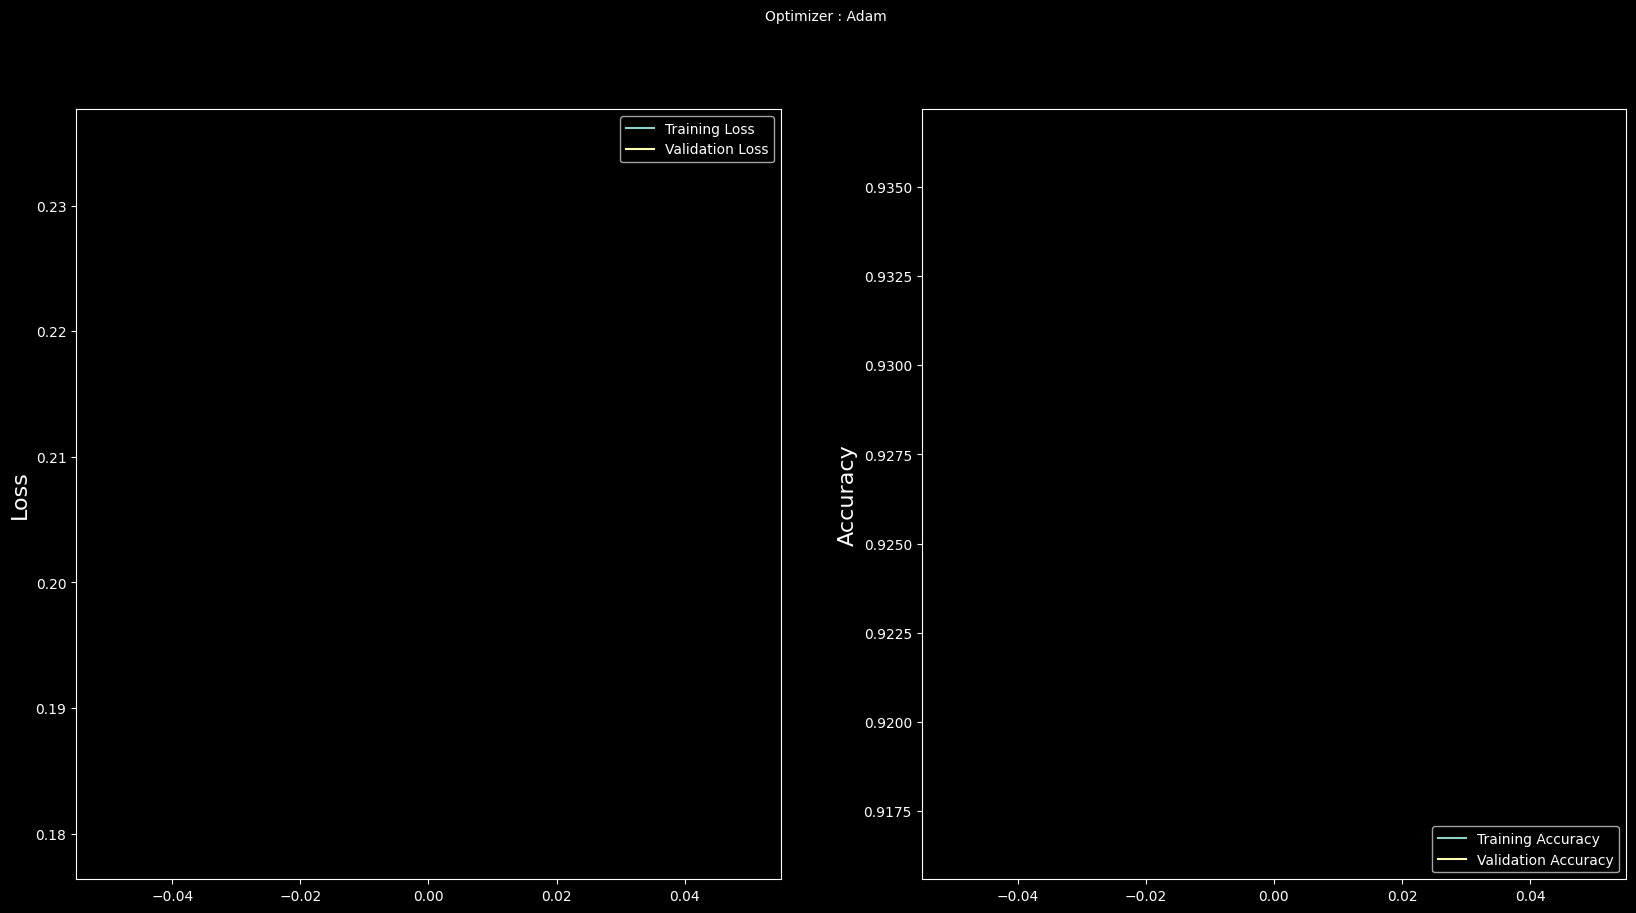

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [74]:
model.save("eye_model.h5")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
model_json=model.to_json()
with open("modeleye_a.json","w") as json_file:
    json_file.write(model_json)